<a href="https://colab.research.google.com/github/urmipandya123/Road_Severity_Classification/blob/main/RTA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install --quiet shap==0.39.0

In [ ]:
pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import plotly.express as px
import plotly.offline as py
import plotly.graph_objs as go
import plotly.tools as tls
import plotly.figure_factory as ff
import plotly.io as pio
pio.renderers.default='notebook'

from collections import Counter
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import cross_val_score, StratifiedKFold, KFold

from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.metrics import (accuracy_score, 
                            classification_report,
                            recall_score, precision_score, f1_score,
                            confusion_matrix)
from mlxtend.evaluate import mcnemar_table, mcnemar_tables
from mlxtend.plotting import checkerboard_plot, plot_decision_regions
from xgboost import XGBClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier
# from mlxtend.evaluate import bias_variance_decomp
from sklearn.decomposition import PCA
%matplotlib inline

sns.set_style('darkgrid')
pd. set_option("display.max_columns", None)

import warnings
warnings.filterwarnings('ignore')

# py.init_notebook_mode()

In [ ]:
df = pd.read_csv("RTA Dataset.csv")

In [ ]:
df.shape

(12316, 32)

In [ ]:
df.head()


Time Day_of_week Age_band_of_driver Sex_of_driver   Educational_level  \
0  17:02:00      Monday              18-30          Male   Above high school   
1  17:02:00      Monday              31-50          Male  Junior high school   
2  17:02:00      Monday              18-30          Male  Junior high school   
3   1:06:00      Sunday              18-30          Male  Junior high school   
4   1:06:00      Sunday              18-30          Male  Junior high school   

  Vehicle_driver_relation Driving_experience      Type_of_vehicle  \
0                Employee              1-2yr           Automobile   
1                Employee         Above 10yr  Public (> 45 seats)   
2                Employee              1-2yr      Lorry (41?100Q)   
3                Employee             5-10yr  Public (> 45 seats)   
4                Employee              2-5yr                  NaN   

  Owner_of_vehicle Service_year_of_vehicle Defect_of_vehicle  \
0            Owner              Above 10yr         No defect   
1            Owner                 5-10yrs         No defect   
2            Owner                     NaN         No defect   
3     Governmental                     NaN         No defect   
4            Owner                 5-10yrs         No defect   

  Area_accident_occured   Lanes_or_Medians  \
0     Residential areas                NaN   
1          Office areas  Undivided Two way   
2    Recreational areas              other   
3          Office areas              other   
4      Industrial areas              other   

                                 Road_allignment Types_of_Junction  \
0                 Tangent road with flat terrain       No junction   
1                 Tangent road with flat terrain       No junction   
2                                            NaN       No junction   
3  Tangent road with mild grade and flat terrain           Y Shape   
4                 Tangent road with flat terrain           Y Shape   

  Road_surface_type Road_surface_conditions       Light_conditions  \
0     Asphalt roads                     Dry               Daylight   
1     Asphalt roads                     Dry               Daylight   
2     Asphalt roads                     Dry               Daylight   
3       Earth roads                     Dry  Darkness - lights lit   
4     Asphalt roads                     Dry  Darkness - lights lit   

  Weather_conditions                        Type_of_collision  \
0             Normal  Collision with roadside-parked vehicles   
1             Normal           Vehicle with vehicle collision   
2             Normal          Collision with roadside objects   
3             Normal           Vehicle with vehicle collision   
4             Normal           Vehicle with vehicle collision   

   Number_of_vehicles_involved  Number_of_casualties Vehicle_movement  \
0                            2                     2   Going straight   
1                            2                     2   Going straight   
2                            2                     2   Going straight   
3                            2                     2   Going straight   
4                            2                     2   Going straight   

    Casualty_class Sex_of_casualty Age_band_of_casualty Casualty_severity  \
0               na              na                   na                na   
1               na              na                   na                na   
2  Driver or rider            Male                31-50                 3   
3       Pedestrian          Female                18-30                 3   
4               na              na                   na                na   

  Work_of_casuality Fitness_of_casuality Pedestrian_movement  \
0               NaN                  NaN    Not a Pedestrian   
1               NaN                  NaN    Not a Pedestrian   
2            Driver                  NaN    Not a Pedestrian   
3            Driver               Normal    Not a Pedestri

In [ ]:
df.tail()

Time Day_of_week Age_band_of_driver Sex_of_driver  \
12311  16:15:00   Wednesday              31-50          Male   
12312  18:00:00      Sunday            Unknown          Male   
12313  13:55:00      Sunday            Over 51          Male   
12314  13:55:00      Sunday              18-30        Female   
12315  13:55:00      Sunday              18-30          Male   

        Educational_level Vehicle_driver_relation Driving_experience  \
12311                 NaN                Employee              2-5yr   
12312   Elementary school                Employee             5-10yr   
12313  Junior high school                Employee             5-10yr   
12314  Junior high school                Employee         Above 10yr   
12315  Junior high school                Employee             5-10yr   

       Type_of_vehicle Owner_of_vehicle Service_year_of_vehicle  \
12311   Lorry (11?40Q)            Owner                     NaN   
12312       Automobile            Owner                     NaN   
12313            Bajaj            Owner                  2-5yrs   
12314  Lorry (41?100Q)            Owner                  2-5yrs   
12315            Other            Owner                  2-5yrs   

      Defect_of_vehicle Area_accident_occured  \
12311         No defect   Outside rural areas   
12312         No defect   Outside rural areas   
12313         No defect   Outside rural areas   
12314         No defect          Office areas   
12315         No defect   Outside rural areas   

                                       Lanes_or_Medians  \
12311                                 Undivided Two way   
12312  Two-way (divided with broken lines road marking)   
12313  Two-way (divided with broken lines road marking)   
12314                                 Undivided Two way   
12315                                 Undivided Two way   

                                 Road_allignment Types_of_Junction  \
12311             Tangent road with flat terrain       No junction   
12312                                Escarpments       No junction   
12313  Tangent road with mountainous terrain and       No junction   
12314  Tangent road with mountainous terrain and       No junction   
12315  Tangent road with mountainous terrain and           O Shape   

      Road_surface_type Road_surface_conditions       Light_conditions  \
12311     Asphalt roads                     Dry               Daylight   
12312     Asphalt roads                     Dry               Daylight   
12313     Asphalt roads                     Dry               Daylight   
12314     Asphalt roads                     Dry  Darkness - lights lit   
12315     Asphalt roads                     Dry  Darkness - lights lit   

      Weather_conditions               Type_of_collision  \
12311             Normal  Vehicle with vehicle collision   
12312             Normal  Vehicle with vehicle collision   
12313             Normal  Vehicle with vehicle collision   
12314             Normal  Vehicle with vehicle collision   
12315             Normal  Vehicle with vehicle collision   

       Number_of_vehicles_involved  Number_of_casualties Vehicle_movement  \
12311                            2                     1   Going straight   
12312                            2                     1            Other   
12313                            1                     1            Other   
12314                            2                     1            Other   
12315                            2                     1         Stopping   

        Casualty_class Sex_of_casualty Age_band_of_casualty Casualty_severity  \
12311               na              na                   na                na   
12312               na              na                   na                na   
12313  Driver or rider            Male                31-50                 3   
12314               na              na                   na                na   
12315       Pedestrian          Female       

In [ ]:
df.sample(4)

Time Day_of_week Age_band_of_driver Sex_of_driver  \
4354  20:30:00     Tuesday              31-50          Male   
63    16:55:00      Sunday              31-50          Male   
852   13:05:00      Friday              31-50          Male   
4050  12:00:00    Saturday            Over 51          Male   

       Educational_level Vehicle_driver_relation Driving_experience  \
4354  Junior high school                   Owner              2-5yr   
63     Elementary school                Employee             5-10yr   
852   Junior high school                   Owner                NaN   
4050  Junior high school                   Owner             5-10yr   

        Type_of_vehicle Owner_of_vehicle Service_year_of_vehicle  \
4354       Stationwagen            Owner                   1-2yr   
63    Public (12 seats)     Organization              Above 10yr   
852     Lorry (41?100Q)            Owner                 Unknown   
4050         Automobile            Owner                  2-5yrs   

     Defect_of_vehicle Area_accident_occured  \
4354         No defect    Recreational areas   
63                 NaN        Hospital areas   
852          No defect          Office areas   
4050         No defect                 Other   

                                      Lanes_or_Medians  \
4354  Two-way (divided with broken lines road marking)   
63    Two-way (divided with broken lines road marking)   
852                                  Undivided Two way   
4050                                 Undivided Two way   

                     Road_allignment Types_of_Junction Road_surface_type  \
4354  Tangent road with flat terrain       No junction     Asphalt roads   
63    Tangent road with flat terrain           Y Shape     Asphalt roads   
852   Tangent road with flat terrain             Other     Asphalt roads   
4050  Tangent road with flat terrain           O Shape     Asphalt roads   

     Road_surface_conditions Light_conditions Weather_conditions  \
4354                     Dry         Daylight             Normal   
63                       Dry         Daylight             Normal   
852                      Dry         Daylight             Normal   
4050                     Dry         Daylight            Unknown   

                   Type_of_collision  Number_of_vehicles_involved  \
4354  Vehicle with vehicle collision                            2   
63    Vehicle with vehicle collision                            2   
852   Vehicle with vehicle collision                            2   
4050          Collision with animals                            2   

      Number_of_casualties Vehicle_movement   Casualty_class Sex_of_casualty  \
4354                     2   Going straight               na              na   
63                       1   Going straight               na              na   
852                      2   Going straight  Driver or rider            Male   
4050                     1  Moving Backward               na              na   

     Age_band_of_casualty Casualty_severity Work_of_casuality  \
4354                   na                na            Driver   
63                     na                na            Driver   
852                 18-30                 2          Employee   
4050                   na                na            Driver   

     Fitness_of_casuality Pedestrian_movement          Cause_of_accident  \
4354               Normal    Not a Pedestrian            Moving Backward   
63                 Normal    Not a Pedestrian        Driving to the left   
852                Normal    Not a Pedestrian                 Overtaking   
4050               Normal    Not a Pedestrian  No priority to pedestrian   

     Accident_severity  
4354     Slight Injury  
63       Slight Injury  
852     Serious Injury  
4050     Slight Injury

# <span style="font-family:cursive;text-align:center">📊 Exploratory Data Analysis</span>

<div class="alert alert-block alert-info" style="font-size:14px; font-family:verdana; line-height: 1.7em;">
    📌 &nbsp;<b>To check shape of the dataframe use .shape() function which return (rows,columns)</b><br>
    📌 &nbsp;<b>To see the name of columns use .columns function which returns name of columns as a list</b><br>
</div>

In [ ]:
df.columns

Index(['Time', 'Day_of_week', 'Age_band_of_driver', 'Sex_of_driver',
       'Educational_level', 'Vehicle_driver_relation', 'Driving_experience',
       'Type_of_vehicle', 'Owner_of_vehicle', 'Service_year_of_vehicle',
       'Defect_of_vehicle', 'Area_accident_occured', 'Lanes_or_Medians',
       'Road_allignment', 'Types_of_Junction', 'Road_surface_type',
       'Road_surface_conditions', 'Light_conditions', 'Weather_conditions',
       'Type_of_collision', 'Number_of_vehicles_involved',
       'Number_of_casualties', 'Vehicle_movement', 'Casualty_class',
       'Sex_of_casualty', 'Age_band_of_casualty', 'Casualty_severity',
       'Work_of_casuality', 'Fitness_of_casuality', 'Pedestrian_movement',
       'Cause_of_accident', 'Accident_severity'],
      dtype='object')

In [ ]:
col_map={
    'Time': 'time',
    'Day_of_week': 'day_of_week',
    'Age_band_of_driver': 'driver_age',
    'Sex_of_driver': 'driver_sex',
    'Educational_level': 'educational_level',
    'Vehicle_driver_relation': 'vehicle_driver_relation',
    'Driving_experience': 'driving_experience',
    'Type_of_vehicle': 'vehicle_type',
    'Owner_of_vehicle': 'vehicle_owner',
    'Service_year_of_vehicle': 'service_year',
    'Defect_of_vehicle': 'vehicle_defect',
    'Area_accident_occured': 'accident_area',
    'Lanes_or_Medians': 'lanes',
    'Road_allignment': 'road_allignment',
    'Types_of_Junction': 'junction_type',
    'Road_surface_type': 'surface_type',
    'Road_surface_conditions': 'road_surface_conditions',
    'Light_conditions': 'light_condition',
    'Weather_conditions': 'weather_condition',
    'Type_of_collision': 'collision_type',
    'Number_of_vehicles_involved': 'vehicles_involved',
    'Number_of_casualties': 'casualties',
    'Vehicle_movement': 'vehicle_movement',
    'Casualty_class': 'casualty_class',
    'Sex_of_casualty': 'casualty_sex' , 
    'Age_band_of_casualty': 'casualty_age', 
    'Casualty_severity': 'casualty_severity',
    'Work_of_casuality': 'casualty_work', 
    'Fitness_of_casuality': 'casualty_fitness',
    'Pedestrian_movement': 'pedestrian_movement',
    'Cause_of_accident': 'accident_cause',
    'Accident_severity': 'accident_severity'
}
df.rename(columns=col_map, inplace=True)

<div class="alert alert-block alert-info" style="font-size:14px; font-family:verdana; line-height: 1.7em;">
    📌 &nbsp;<b> .info() prints information about a DataFrame including the index dtype and columns, non-null values and memory usage.</b><br>
    📌 &nbsp;<b>.describe(): Descriptive statistics include those that summarize the central tendency, dispersion and shape of a dataset’s distribution, excluding NaN values.</b><br>
</div>

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12316 entries, 0 to 12315
Data columns (total 32 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   time                     12316 non-null  object
 1   day_of_week              12316 non-null  object
 2   driver_age               12316 non-null  object
 3   driver_sex               12316 non-null  object
 4   educational_level        11575 non-null  object
 5   vehicle_driver_relation  11737 non-null  object
 6   driving_experience       11487 non-null  object
 7   vehicle_type             11366 non-null  object
 8   vehicle_owner            11834 non-null  object
 9   service_year             8388 non-null   object
 10  vehicle_defect           7889 non-null   object
 11  accident_area            12077 non-null  object
 12  lanes                    11931 non-null  object
 13  road_allignment          12174 non-null  object
 14  junction_type            11429 non-nul

In [ ]:
df.describe()

vehicles_involved    casualties
count       12316.000000  12316.000000
mean            2.040679      1.548149
std             0.688790      1.007179
min             1.000000      1.000000
25%             2.000000      1.000000
50%             2.000000      1.000000
75%             2.000000      2.000000
max             7.000000      8.000000

In [ ]:
df.describe(include=['O']).T # to include categorical columns


count unique  \
time                     12316   1074   
day_of_week              12316      7   
driver_age               12316      5   
driver_sex               12316      3   
educational_level        11575      7   
vehicle_driver_relation  11737      4   
driving_experience       11487      7   
vehicle_type             11366     17   
vehicle_owner            11834      4   
service_year              8388      6   
vehicle_defect            7889      3   
accident_area            12077     14   
lanes                    11931      7   
road_allignment          12174      9   
junction_type            11429      8   
surface_type             12144      5   
road_surface_conditions  12316      4   
light_condition          12316      4   
weather_condition        12316      9   
collision_type           12161     10   
vehicle_movement         12008     13   
casualty_class           12316      4   
casualty_sex             12316      3   
casualty_age             12316      6   
casualty_severity        12316      4   
casualty_work             9118      7   
casualty_fitness          9681      5   
pedestrian_movement      12316      9   
accident_cause           12316     20   
accident_severity        12316      3   

                                                                      top  \
time                                                             15:30:00   
day_of_week                                                        Friday   
driver_age                                                          18-30   
driver_sex                                                           Male   
educational_level                                      Junior high school   
vehicle_driver_relation                                          Employee   
driving_experience                                                 5-10yr   
vehicle_type                                                   Automobile   
vehicle_owner                                                       Owner   
service_year                                                      Unknown   
vehicle_defect                                                  No defect   
accident_area                                                       Other   
lanes                    Two-way (divided with broken lines road marking)   
road_allignment                            Tangent road with flat terrain   
junction_type                                                     Y Shape   
surface_type                                                Asphalt roads   
road_surface_conditions                                               Dry   
light_condition                                                  Daylight   
weather_condition                                                  Normal   
collision_type                             Vehicle with vehicle collision   
vehicle_movement                                           Going straight   
casualty_class                                            Driver or rider   
casualty_sex                                                         Male   
casualty_age                                                           na   
casualty_severity                                                       3   
casualty_work                                                      Driver   
casualty_fitness                                                   Normal   
pedestrian_movement                                      Not a Pedestrian   
accident_cause                                              No distancing   
accident_severity                                           Slight Injury   

                          freq  
time                       120  
day_of_week               2041  
driver_age                4271  
driver_sex               11437  
educational_level         7619  
vehicle_driver_relation   9627  
driving_experience        3363  
vehicle_type              3205  
vehicle_owner            10459  
service_year              2883  
ve

In [ ]:
df.isna().sum() # add .sum() to get total count of missing values in column

time                          0
day_of_week                   0
driver_age                    0
driver_sex                    0
educational_level           741
vehicle_driver_relation     579
driving_experience          829
vehicle_type                950
vehicle_owner               482
service_year               3928
vehicle_defect             4427
accident_area               239
lanes                       385
road_allignment             142
junction_type               887
surface_type                172
road_surface_conditions       0
light_condition               0
weather_condition             0
collision_type              155
vehicles_involved             0
casualties                    0
vehicle_movement            308
casualty_class                0
casualty_sex                  0
casualty_age                  0
casualty_severity             0
casualty_work              3198
casualty_fitness           2635
pedestrian_movement           0
accident_cause                0
accident

In [ ]:
print("Number of duplicates: ", df.duplicated().sum())

Number of duplicates:  0


In [ ]:
print("Unique values per column:")
df.nunique()

Unique values per column:


time                       1074
day_of_week                   7
driver_age                    5
driver_sex                    3
educational_level             7
vehicle_driver_relation       4
driving_experience            7
vehicle_type                 17
vehicle_owner                 4
service_year                  6
vehicle_defect                3
accident_area                14
lanes                         7
road_allignment               9
junction_type                 8
surface_type                  5
road_surface_conditions       4
light_condition               4
weather_condition             9
collision_type               10
vehicles_involved             6
casualties                    8
vehicle_movement             13
casualty_class                4
casualty_sex                  3
casualty_age                  6
casualty_severity             4
casualty_work                 7
casualty_fitness              5
pedestrian_movement           9
accident_cause               20
accident

In [ ]:
for i in df.columns:
    print(f"Unique value in {i}:")
    print(df[i].unique(),'\n')

Unique value in time:
['17:02:00' '1:06:00' '14:15:00' ... '7:24:00' '19:18:00' '2:47:00'] 

Unique value in day_of_week:
['Monday' 'Sunday' 'Friday' 'Wednesday' 'Saturday' 'Thursday' 'Tuesday'] 

Unique value in driver_age:
['18-30' '31-50' 'Under 18' 'Over 51' 'Unknown'] 

Unique value in driver_sex:
['Male' 'Female' 'Unknown'] 

Unique value in educational_level:
['Above high school' 'Junior high school' nan 'Elementary school'
 'High school' 'Unknown' 'Illiterate' 'Writing & reading'] 

Unique value in vehicle_driver_relation:
['Employee' 'Unknown' 'Owner' nan 'Other'] 

Unique value in driving_experience:
['1-2yr' 'Above 10yr' '5-10yr' '2-5yr' nan 'No Licence' 'Below 1yr'
 'unknown'] 

Unique value in vehicle_type:
['Automobile' 'Public (> 45 seats)' 'Lorry (41?100Q)' nan
 'Public (13?45 seats)' 'Lorry (11?40Q)' 'Long lorry' 'Public (12 seats)'
 'Taxi' 'Pick up upto 10Q' 'Stationwagen' 'Ridden horse' 'Other' 'Bajaj'
 'Turbo' 'Motorcycle' 'Special vehicle' 'Bicycle'] 

Unique value

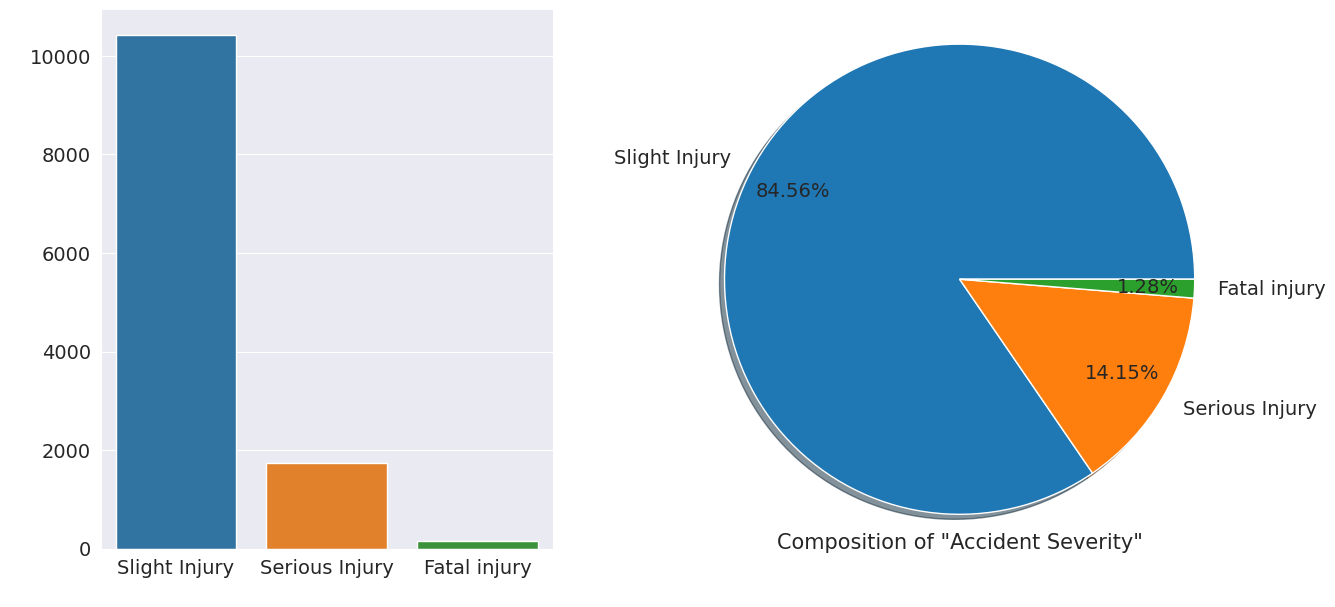

In [ ]:
# checking the target
plt.figure(figsize=(14,7))
# barplot
ax1 = plt.subplot(1,2,1)
cp = sns.countplot(x=df["accident_severity"])
ax1.set_xlabel(" ")
ax1.set_ylabel(" ")
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
sns.despine(top=True, right=True)
# pieplot
ax2 = plt.subplot(1,2,2)
plt.pie(df["accident_severity"].value_counts(),
        labels=list(df["accident_severity"].unique()),
        autopct='%1.2f%%',
        pctdistance=0.8,
        shadow=True,
        radius=1.3,
        textprops={'fontsize':14}
       )
ax2.set_xlabel(" ")
plt.xlabel('Composition of "Accident Severity"', fontsize=15, labelpad=20)
plt.subplots_adjust(wspace=0.4)
plt.show()

In [ ]:
fig = px.treemap(df, path=['accident_cause'], width=800, height=400)
fig.update_layout(
    margin = dict(t=50, l=25, r=25, b=25))
# fig.show()

py.init_notebook_mode(connected=True)
py.iplot(fig,filename= "treemap")

In [ ]:
# converting 'time' to datetime
df['time'] = pd.to_datetime(df['time'])

# date (day-month-year) time
df["time"].dt.hour

# extracting hour and minute from timestamp
df['hour'] = df['time'].dt.hour
df['minute'] = df['time'].dt.minute
df.drop('time', axis=1, inplace=True)

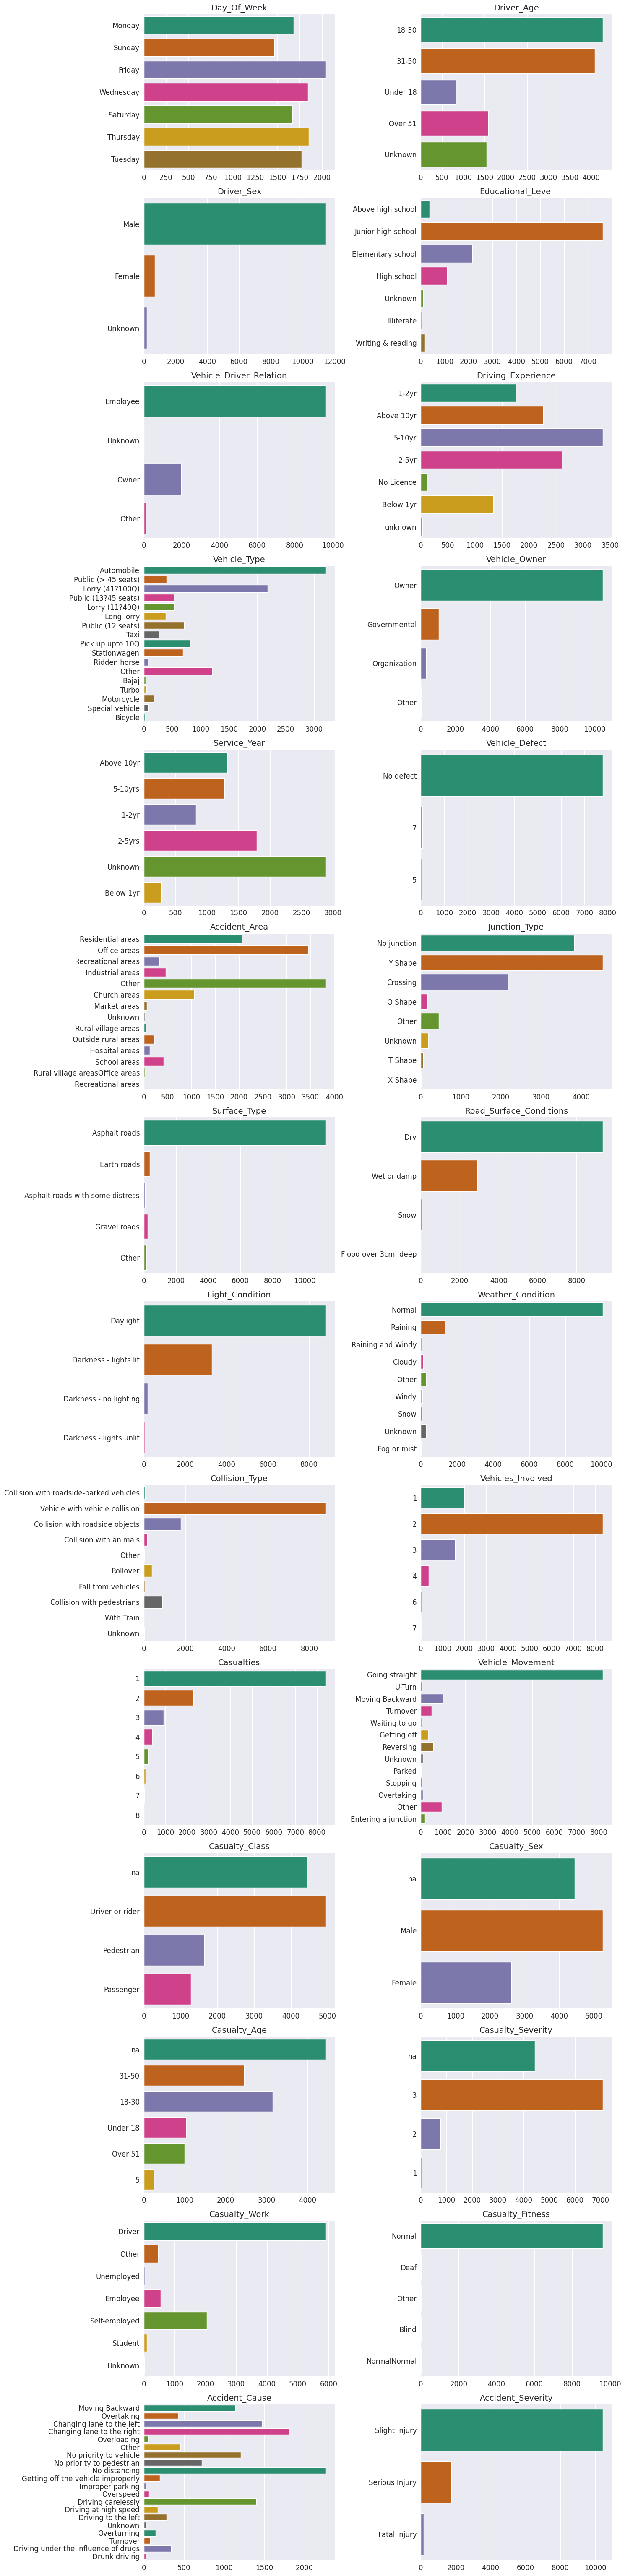

In [ ]:
plt.figure(figsize=(15,70))
plotnumber = 1

for col in df.drop(['hour', 'minute', 'lanes', 'road_allignment', 'pedestrian_movement'], axis=1):
    if plotnumber <= df.shape[1]:
        ax1 = plt.subplot(16,2,plotnumber)
        sns.countplot(data=df, y=col, palette='Dark2')
        plt.xticks(fontsize=12)
        plt.yticks(fontsize=12)
        plt.title(col.title(), fontsize=14)
        plt.xlabel('')
        plt.ylabel('')
    plotnumber +=1
plt.tight_layout()

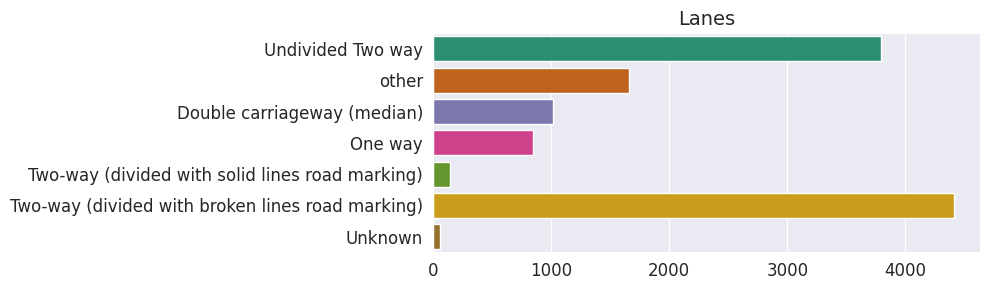

In [ ]:
plt.figure(figsize=(10,3))
sns.countplot(data=df, y='lanes', palette = 'Dark2')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title('Lanes', fontsize=14)
plt.xlabel('')
plt.ylabel('')
plt.tight_layout()

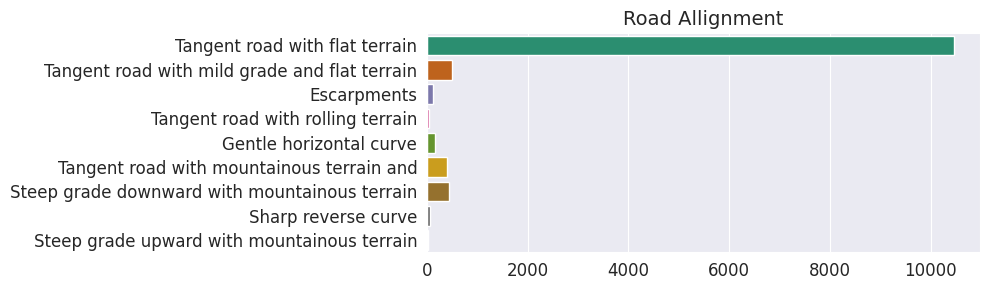

In [ ]:
plt.figure(figsize=(10,3))
sns.countplot(data=df, y='road_allignment', palette = 'Dark2')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title('Road Allignment', fontsize=14)
plt.xlabel('')
plt.ylabel('')
plt.tight_layout()

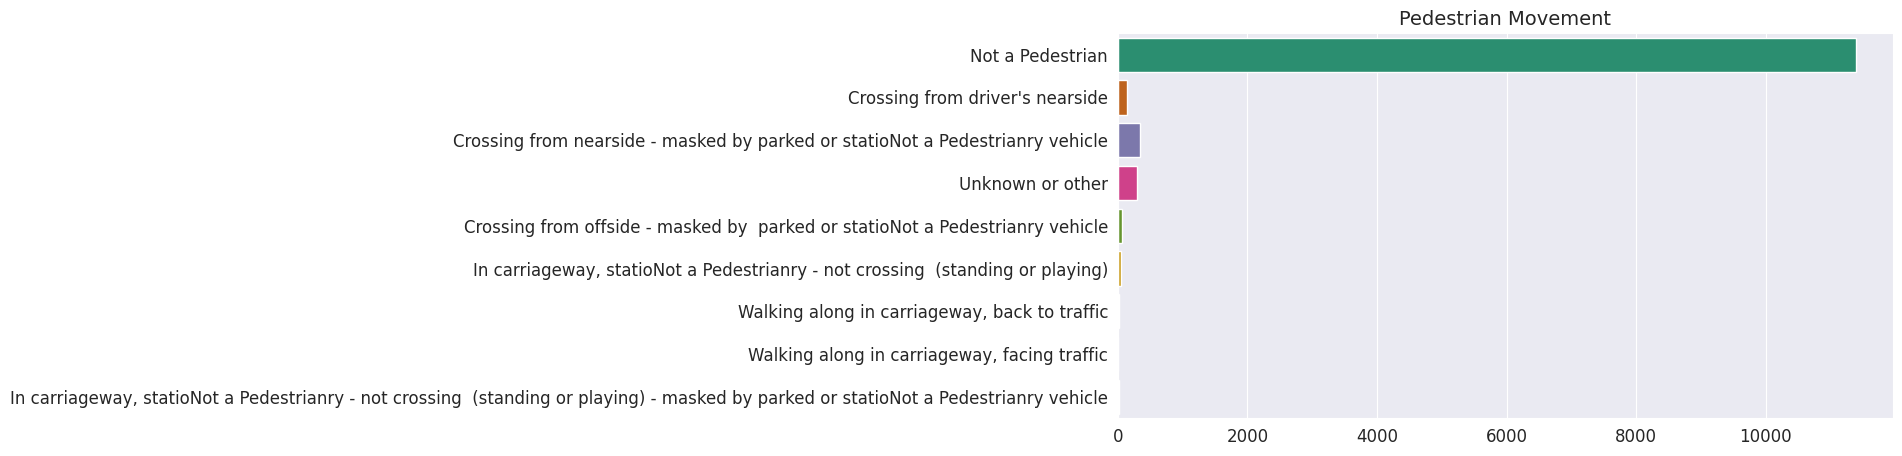

In [ ]:
plt.figure(figsize=(10,5))
sns.countplot(data=df, y='pedestrian_movement', palette = 'Dark2')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title('Pedestrian Movement', fontsize=14)
plt.xlabel('')
plt.ylabel('')
plt.tight_layout()

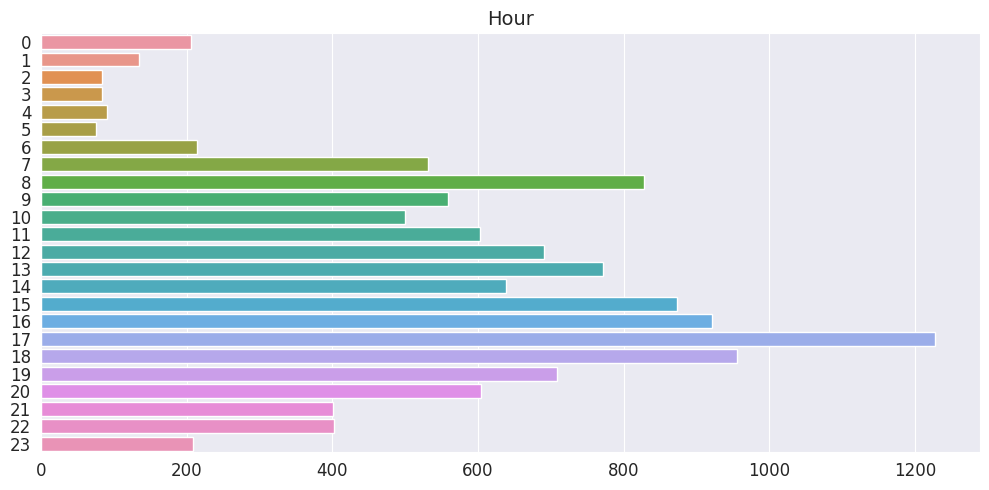

In [ ]:
plt.figure(figsize=(10,5))
sns.countplot(data=df, y='hour')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title('Hour', fontsize=14)
plt.xlabel('')
plt.ylabel('')
plt.tight_layout()

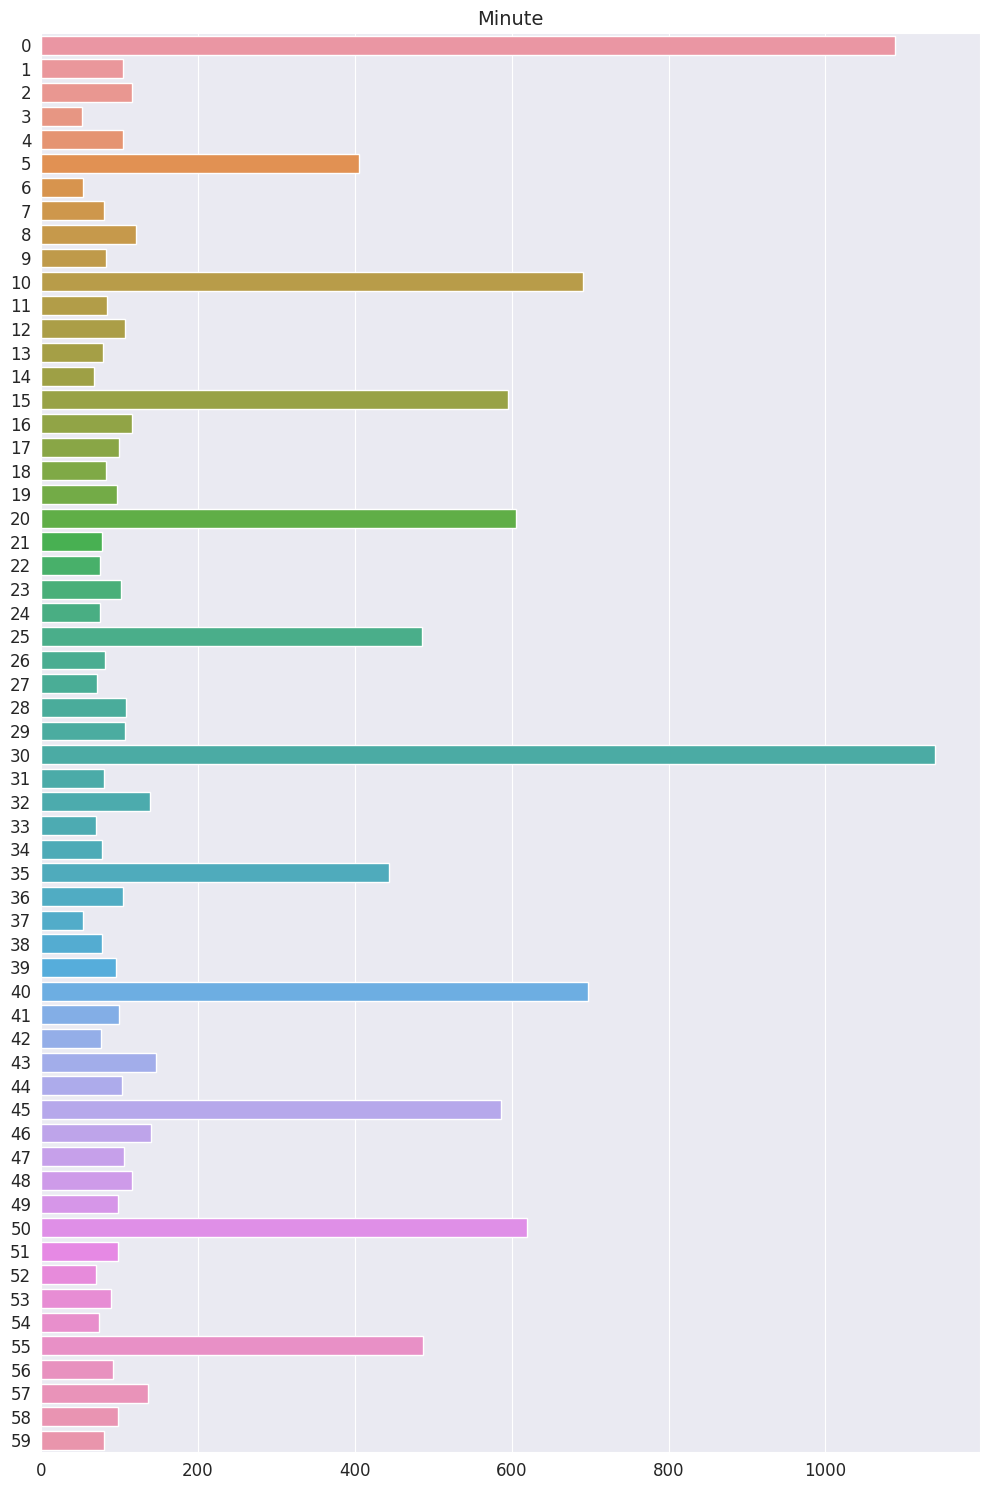

In [ ]:
plt.figure(figsize=(10,15))
sns.countplot(data=df, y='minute')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title('Minute', fontsize=14)
plt.xlabel('')
plt.ylabel('')
plt.tight_layout()

<div style="border-radius:10px; border:#DEB887 solid; padding: 15px; background-color: #FFFAF0; font-size:100%; text-align:left">
<h3 align="left"><font color='#DEB887'>💡 Observations:</font></h3>

Most of the accidents:
* involved 2 vehicles and 2 casualties
* occured on Fridays and after noon hours

Most of the drivers:
* are male and in 18-30 yrs age group
* have only went upto Junior high school and are employees
* have 5-10 yrs of driving experience

Most of the accidents happened with personally owned passenger vehicles.

Most of the drivers have met with accident on:
* two-way lanes
* tangent road with flat terrains
* Y shaped junctions
* asphalt roads
* day time
* normal weather conditions

Most of the casualties:
* happened to physically fit male drivers
* are of severity 3

The conditions on which most of the drivers met with the accident are:
* vehicle to vehicle collision
* straight movement
* no pedestrian accidents

Not keeping enough distance between the vehicles was the major cause for most of the accidents and majority of the accidents resulted in slight injury.
    
</div>

<div style="border-radius:10px; border:#DEB887 solid; padding: 15px; background-color: #FFFAF0; font-size:100%; text-align:left">
<h3 align="left"><font color='#DEB887'>💡 Observations:</font></h3>
    
* Most of the accidents have taken place between 3pm to 6pm with maximum numbers at 5 pm
* Most of the time in minutes seems to have been recorded in intervals of 5 minutes for the sake of convenience. Hence more numbers to be seen at the 0 and 30 minutes.

In [ ]:
min = list(range(5,56, 5))
def convert_minutes(x: int):
    for m in min:
        if x % m == x and x > m-5:
            return m
        if x in [56,57,58,59]:
            return 0
        if x in min+[0]:
            return x

In [ ]:
df['minute'] = df['minute'].apply(lambda x: convert_minutes(x))

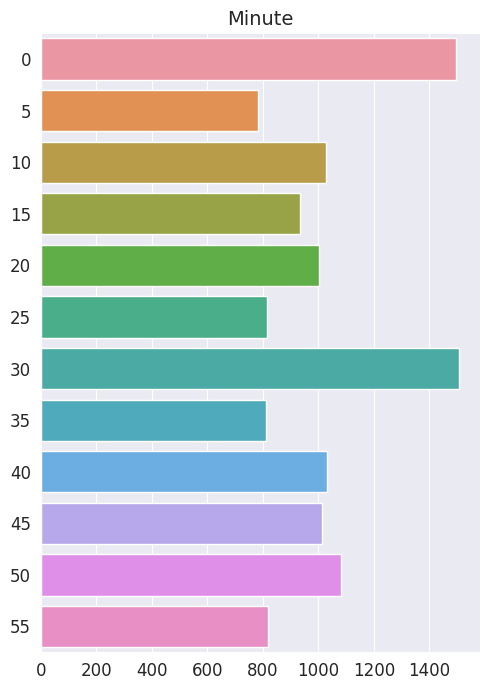

In [ ]:
plt.figure(figsize=(5,7))
sns.countplot(data=df, y='minute')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title('Minute', fontsize=14)
plt.xlabel('')
plt.ylabel('')
plt.tight_layout()

<div style="border-radius:10px; border:#DEB887 solid; padding: 15px; background-color: #FFFAF0; font-size:100%; text-align:left">
<h3 align="left"><font color='#DEB887'>💡 Observations:</font></h3>
    
* Most of the accidents with fatal injuries happened between 2pm to 7pm.
* Most of the accidents with fatal injuries happened on weekends.
* Highest number of non-fatal injuries happened at 5pm.
* Highest number of non-fatal injuries happened on fridays.
* Most accidents are caused by drivers aged 18-30 and the least by drivers aged under 18.
* Proportion of fatal accidents are lower for female drivers.
* Drivers with 2-5yrs of experience caused most accidents with fatal injury and those with 5-10yrs experience caused most accidents with non-fatal injuries.
* Proportion of fatal injuries caused by vehicles with more than 10yrs of service is lower compared to non-fatal injuries.
* Though most of the accident happened around offices, a higher proportion of accidents happened around residential areas have led to fatal injuries.
* Most accidents with fatal injuries occured on undivided two-ways.
* Most accidents with non-fatal injuries occured on two-way divided with broken lines road marking
* Double carriageway has a lower proportion of fatal accidents compared to non-fatal accidents.
* Severity of accidents increases at places with no junctions and the most number of fatal injuries occured at places with no junctions.
* Crossings and Y-shaped junctions shows a decreasing trend with respect to severity of accidents though the numbers are high.
* Most of the accidents with fatal injury have happened at night.
* Collisions with pedestrians have resulted in more fatal injuries compared to non-fatal injuries.
* Accidents with 4 casualties have a huge proportion on fatal injuries compared to non-fatal injuries.
* Accidents involving drivers with 18-30yrs of age have an increasing pattern with respect to severity of injuries.
* Moving backward led to most of the accidents with fatal injuries whereas failing to keep enough distance between vehicles led to more number of accidents with non-fatal injuries.

In [ ]:
hypothesis_df = df.copy(deep=True)

<div style="border-radius:10px; border: #0080FF solid; padding: 15px; background-color: #CEF6F5; font-size:100%; text-align:left">
<h2 align="left"><font color='#0080FF'>Hypothesis 1: Which of both genders is actually dangerous in Driving?</font></h2>
    
<font color='#0080FF'><b>Calculating the Conditional Probability; Probability of an Accident Happen When the Driver is a Female and Repeating the Calculations when it's Male.<br>
P(Gender = Male | Severity = 2) P(Gender = Female | Severity = 2)</b></font>

In [ ]:
((hypothesis_df.groupby(['driver_sex']).size() / hypothesis_df["driver_sex"].count()) * 100).add_prefix('Accidents(in %) Caused by ')

driver_sex
Accidents(in %) Caused by Female      5.691783
Accidents(in %) Caused by Male       92.862943
Accidents(in %) Caused by Unknown     1.445274
dtype: float64

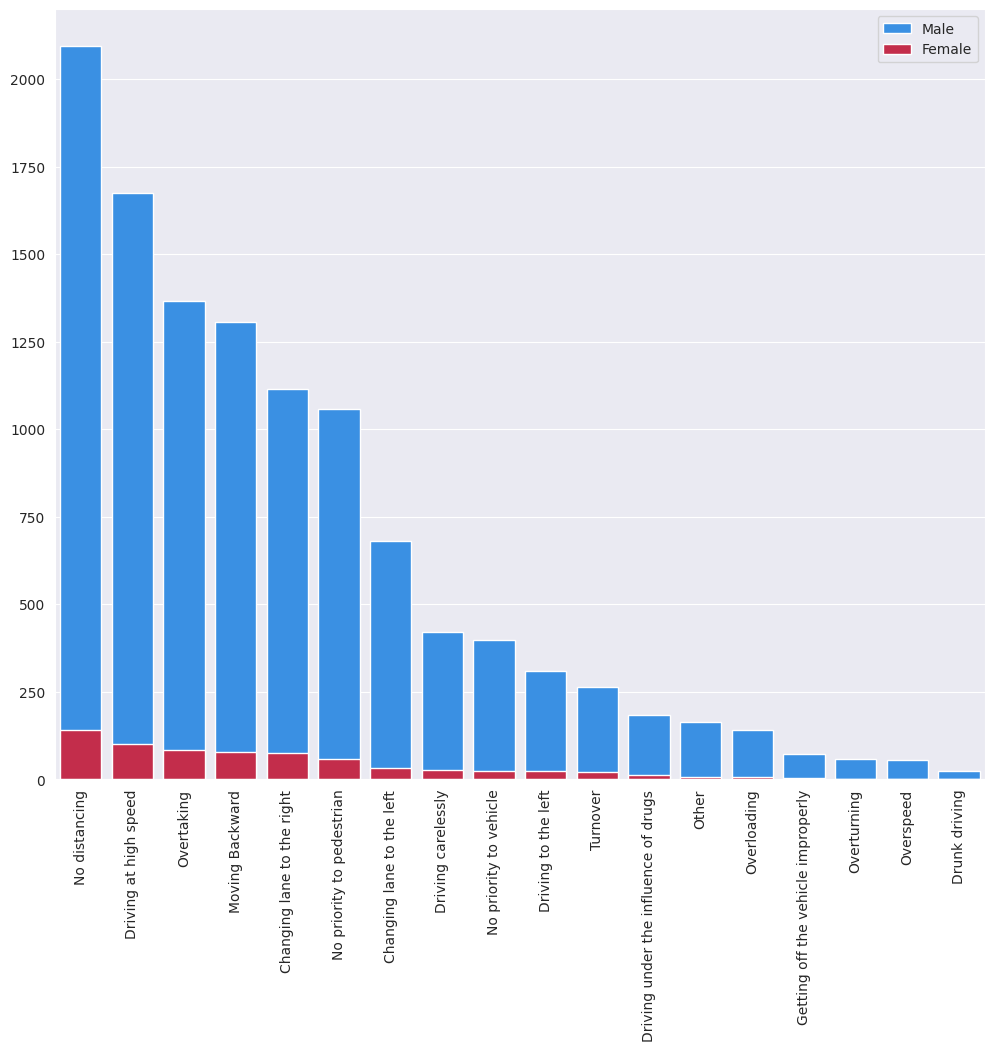

In [ ]:
plt.figure(figsize=(12,10))
male_df = hypothesis_df.loc[hypothesis_df.driver_sex == 'Male']
female_df = hypothesis_df.loc[hypothesis_df.driver_sex == 'Female']
sns.barplot(data=male_df,x = male_df.accident_cause.unique(),y = male_df.accident_cause.value_counts().values,color='dodgerblue', label="Male")
sns.barplot(data=female_df,x = female_df.accident_cause.unique(),y = female_df.accident_cause.value_counts().values,color='crimson', label="Female")
plt.xticks(rotation=90)
plt.legend()
plt.show()

In [ ]:
ff = pd.crosstab(index=hypothesis_df['driver_sex'].loc[hypothesis_df['driver_sex'] !="Unknown"], columns=df['accident_severity']
                 , margins=True)
ff

accident_severity  Fatal injury  Serious Injury  Slight Injury    All
driver_sex                                                           
Female                        5             104            592    701
Male                        152            1621           9664  11437
All                         157            1725          10256  12138

In [ ]:
print("P(Gender = Female | Severity = Fatal) = " + str((ff.iloc[0,0])/(ff.iloc[0,3]*1.0)*100) + '%')
print("P(Gender = Male | Severity = Fatal) = " + str((ff.iloc[1,0])/(ff.iloc[1,3]*1.0)*100) + '%\n')

print("P(Gender = Female | Severity = Serious Injury) = " + str((ff.iloc[0,1])/(ff.iloc[0,3]*1.0)*100) + '%')
print("P(Gender = Male | Severity = Serious Injury) = " + str((ff.iloc[1,1])/(ff.iloc[1,3]*1.0)*100) + '%\n')

print("P(Gender = Female | Severity = Slight Injury) = " + str((ff.iloc[0,2])/(ff.iloc[0,3]*1.0)*100) + '%')
print("P(Gender = Male | Severity = Slight Injury) = " + str((ff.iloc[1,2])/(ff.iloc[1,3]*1.0)*100) + '%')

P(Gender = Female | Severity = Fatal) = 0.7132667617689016%
P(Gender = Male | Severity = Fatal) = 1.3290198478622017%

P(Gender = Female | Severity = Serious Injury) = 14.835948644793154%
P(Gender = Male | Severity = Serious Injury) = 14.173297193319925%

P(Gender = Female | Severity = Slight Injury) = 84.45078459343794%
P(Gender = Male | Severity = Slight Injury) = 84.49768295881788%


<div style="border-radius:10px; border:#DEB887 solid; padding: 15px; background-color: #FFFAF0; font-size:100%; text-align:left">
<h3 align="left"><font color='#DEB887'>Observation:</font></h3>
    
Although, the percentage of Accidents done in this sample by males is over 92% but, it doesn't actually indicate that males are more dangerous
If we calculated the probability for each gender we can deduce that both are quite the same.

<div style="border-radius:10px; border: #0080FF solid; padding: 15px; background-color: #CEF6F5; font-size:100%; text-align:left">
<h2 align="left"><font color='#0080FF'>Hypothesis 2: Is Speeding is the main Cause for Car Crashes?</font></h2><br>

In [ ]:
ff = pd.crosstab(index=hypothesis_df['accident_cause'], columns=hypothesis_df['accident_severity'], margins=True)
pd.crosstab(index=hypothesis_df['accident_cause'], columns=hypothesis_df['accident_severity'], margins=True)
ff

accident_severity                     Fatal injury  Serious Injury  \
accident_cause                                                       
Changing lane to the left                       16             206   
Changing lane to the right                      23             260   
Driving at high speed                            2              31   
Driving carelessly                              22             209   
Driving to the left                              4              53   
Driving under the influence of drugs             5              46   
Drunk driving                                    0               3   
Getting off the vehicle improperly               3              29   
Improper parking                                 1               2   
Moving Backward                                 26             162   
No distancing                                   20             303   
No priority to pedestrian                        5              95   
No priority to vehicle                          13             149   
Other                                            7              64   
Overloading                                      2              10   
Overspeed                                        1              15   
Overtaking                                       4              75   
Overturning                                      2              23   
Turnover                                         2               6   
Unknown                                          0               2   
All                                            158            1743   

accident_severity                     Slight Injury    All  
accident_cause                                              
Changing lane to the left                      1251   1473  
Changing lane to the right                     1525   1808  
Driving at high speed                           141    174  
Driving carelessly                             1171   1402  
Driving to the left                             227    284  
Driving under the influence of drugs            289    340  
Drunk driving                                    24     27  
Getting off the vehicle improperly              165    197  
Improper parking                                 22     25  
Moving Backward                                 949   1137  
No distancing                                  1940   2263  
No priority to pedestrian                       621    721  
No priority to vehicle                         1045   1207  
Other                                           385    456  
Overloading                                      47     59  
Overspeed                                        45     61  
Overtaking                                      351    430  
Overturning                                     124    149  
Turnover                                         70     78  
Unknown                                          23     25  
All                                           10415  12316

In [ ]:
print(f'Injuries(all types due to speeding): {ff.iloc[2,2]}/{ff.iloc[3,3]}')
print(f'In percentage: {(ff.iloc[2,2]/ff.iloc[3,3])*100} %')

Injuries(all types due to speeding): 141/1402
In percentage: 10.057061340941512 %


<div style="border-radius:10px; border:#DEB887 solid; padding: 15px; background-color: #FFFAF0; font-size:100%; text-align:left">
<h3 align="left"><font color='#DEB887'>Observation:</font></h3>
    
Despite the fact that speeding causes accidents. After analysis it’s found that speeding is not one of the main factors.

<div style="border-radius:10px; border: #0080FF solid; padding: 15px; background-color: #CEF6F5; font-size:100%; text-align:left">
<h2 align="left"><font color='#0080FF'>Hypothesis 3: Do weekends account for more accidents?</font></h2><br>

In [ ]:
ff = pd.crosstab(index=hypothesis_df['day_of_week'], columns=hypothesis_df['accident_severity'], margins=True)
pd.crosstab(index=hypothesis_df['day_of_week'], columns=hypothesis_df['accident_severity'], margins=True)
ff

accident_severity  Fatal injury  Serious Injury  Slight Injury    All
day_of_week                                                          
Friday                       16             313           1712   2041
Monday                       12             204           1465   1681
Saturday                     37             245           1384   1666
Sunday                       35             190           1242   1467
Thursday                     22             272           1557   1851
Tuesday                      17             257           1496   1770
Wednesday                    19             262           1559   1840
All                         158            1743          10415  12316

In [ ]:
print('Accident percentage on weekdays:',round(sum([ff.iloc[i,3] for i in range(0,7) if ff.index[i] not in ['Saturday','Sunday']])/ff.iloc[7,3],2))
print('Accident percentage on weekends:',round(sum([ff.iloc[i,3] for i in range(0,7) if ff.index[i] in ['Saturday','Sunday']])/ff.iloc[7,3],2))

Accident percentage on weekdays: 0.75
Accident percentage on weekends: 0.25


<div style="border-radius:10px; border:#DEB887 solid; padding: 15px; background-color: #FFFAF0; font-size:100%; text-align:left">
<h3 align="left"><font color='#DEB887'>Observation:</font></h3>
    
Its quite clear that there is no indication of more accidents happening on weekends

<div style="border-radius:10px; border: #0080FF solid; padding: 15px; background-color: #CEF6F5; font-size:100%; text-align:left">
<h2 align="left"><font color='#0080FF'>Hypothesis 4: Are there more dangerous injuries at night than in day? </font></h2><br>
<font color='#0080FF'>We would consider both fatal and serious to be dangerous injuries</font>

In [ ]:
ff = pd.crosstab(index=hypothesis_df['light_condition'], columns=hypothesis_df['accident_severity'], margins=True)
pd.crosstab(index=hypothesis_df['light_condition'], columns=hypothesis_df['accident_severity'], margins=True)
ff

accident_severity        Fatal injury  Serious Injury  Slight Injury    All
light_condition                                                            
Darkness - lights lit              66             465           2755   3286
Darkness - lights unlit             0               7             33     40
Darkness - no lighting              5              49            138    192
Daylight                           87            1222           7489   8798
All                               158            1743          10415  12316

In [ ]:
sol = 0
for i in [0,1]:
    for j in [0,1,2]:
        sol += ff.iloc[j,i]

r = sol/(sum(ff.iloc[i,3] for i in [0,1,2]))
print('Dangerous injuries at night:',round(r,2),'%')
r = sum(ff.iloc[i,2] for i in [0,1,2])/sum(ff.iloc[i,3] for i in [0,1,2])
print('Slight injuries at night:',round(r,2),'%')

Dangerous injuries at night: 0.17 %
Slight injuries at night: 0.83 %


In [ ]:
r = sum(ff.iloc[3,i] for i in [0,1])/ff.iloc[3,3]
print('Dangerous injuries at day:',round(r,2),'%')
r = ff.iloc[3,2]/ff.iloc[3,3]
print('Slight injuries at day:',round(r,2),'%')

Dangerous injuries at day: 0.15 %
Slight injuries at day: 0.85 %


<div style="border-radius:10px; border:#DEB887 solid; padding: 15px; background-color: #FFFAF0; font-size:100%; text-align:left">
<h3 align="left"><font color='#DEB887'>Observation:</font></h3>
    
Although it does that in daylight there are more number of accidents but the dangerous injuries percentage are almost same either be it day or night.

<div style="border-radius:10px; border: #0080FF solid; padding: 15px; background-color: #CEF6F5; font-size:100%; text-align:left">
<h2 align="left"><font color='#0080FF'>Hypothesis 5: More accidents under some specific non-normal weather? </font></h2><br>
<font color='#0080FF'>We would not consider normal weather</font>

In [ ]:
ff = pd.crosstab(index=hypothesis_df['weather_condition'], columns=hypothesis_df['accident_severity'], margins=True)
pd.crosstab(index=hypothesis_df['weather_condition'], columns=hypothesis_df['accident_severity'], margins=True)
ff.drop(['Normal','All'],axis=0)

accident_severity  Fatal injury  Serious Injury  Slight Injury   All
weather_condition                                                   
Cloudy                        0               8            117   125
Fog or mist                   0               1              9    10
Other                         0              28            268   296
Raining                      23             158           1150  1331
Raining and Windy             0               2             38    40
Snow                          0               5             56    61
Unknown                       0              51            241   292
Windy                         0              16             82    98

<div style="border-radius:10px; border:#DEB887 solid; padding: 15px; background-color: #FFFAF0; font-size:100%; text-align:left">
<h3 align="left"><font color='#DEB887'>Observation:</font></h3>
    
Without any analysis we can clearly see that rainy weather causes more accident and also all the fatal injuries have occured under non-normal conditions are there in rainy weather

# <span style="font-family:cursive;text-align:center">⚙️ Preprocessing</span>

In [ ]:
df.isna().sum()

day_of_week                   0
driver_age                    0
driver_sex                    0
educational_level           741
vehicle_driver_relation     579
driving_experience          829
vehicle_type                950
vehicle_owner               482
service_year               3928
vehicle_defect             4427
accident_area               239
lanes                       385
road_allignment             142
junction_type               887
surface_type                172
road_surface_conditions       0
light_condition               0
weather_condition             0
collision_type              155
vehicles_involved             0
casualties                    0
vehicle_movement            308
casualty_class                0
casualty_sex                  0
casualty_age                  0
casualty_severity             0
casualty_work              3198
casualty_fitness           2635
pedestrian_movement           0
accident_cause                0
accident_severity             0
hour    

In [ ]:
# dropping columns that can cause imbalance while imputation
df.drop(columns = ['vehicle_defect', 'vehicle_driver_relation', 'casualty_work', 'casualty_fitness'], inplace=True)

In [ ]:
impute_cols = [x for x in df.isna().sum()[df.isna().sum() != 0].index.tolist()]
for feat in impute_cols:
    mode = df[feat].mode()[0]
    df[feat].fillna(mode, inplace=True)

In [ ]:
df.isna().sum() 

day_of_week                0
driver_age                 0
driver_sex                 0
educational_level          0
driving_experience         0
vehicle_type               0
vehicle_owner              0
service_year               0
accident_area              0
lanes                      0
road_allignment            0
junction_type              0
surface_type               0
road_surface_conditions    0
light_condition            0
weather_condition          0
collision_type             0
vehicles_involved          0
casualties                 0
vehicle_movement           0
casualty_class             0
casualty_sex               0
casualty_age               0
casualty_severity          0
pedestrian_movement        0
accident_cause             0
accident_severity          0
hour                       0
minute                     0
dtype: int64

Encoding

In [ ]:
def ordinal_encoder(df, feats): 
    for feat in feats:    
        feat_val = list(np.arange(df[feat].nunique()))
        feat_key = list(df[feat].sort_values().unique())
        feat_dict = dict(zip(feat_key, feat_val))
        df[feat] = df[feat].map(feat_dict)
    return df

df = ordinal_encoder(df, df.drop(['accident_severity'], axis=1).columns)
df.shape

(12316, 29)

In [ ]:
df.head()

day_of_week  driver_age  driver_sex  educational_level  driving_experience  \
0            1           0           1                  0                   0   
1            1           1           1                  4                   3   
2            1           0           1                  4                   0   
3            3           0           1                  4                   2   
4            3           0           1                  4                   1   

   vehicle_type  vehicle_owner  service_year  accident_area  lanes  \
0             0              3             3              9      2   
1            11              3             2              6      4   
2             5              3             5              1      6   
3            11              0             5              6      6   
4             0              3             2              4      6   

   road_allignment  junction_type  surface_type  road_surface_conditions  \
0                5              1             0                        0   
1                5              1             0                        0   
2                5              1             0                        0   
3                6              7             2                        0   
4                5              7             0                        0   

   light_condition  weather_condition  collision_type  vehicles_involved  \
0                3                  2               3                  1   
1                3                  2               8                  1   
2                3                  2               2                  1   
3                0                  2               8                  1   
4                0                  2               8                  1   

   casualties  vehicle_movement  casualty_class  casualty_sex  casualty_age  \
0           1                 2               3             2             5   
1           1                 2               3             2             5   
2           1                 2               0             1             1   
3           1                 2               2             0             0   
4           1                 2               3             2             5   

   casualty_severity  pedestrian_movement  accident_cause accident_severity  \
0                  3                    5               9     Slight Injury   
1                  3                    5              16     Slight Injury   
2                  2                    5               0    Serious Injury   
3                  2                    5               1     Slight Injury   
4                  3                    5              16     Slight Injury   

   hour  minute  
0    17       1  
1    17       1  
2    17       1  
3     1       2  
4     1       2

<Axes: >

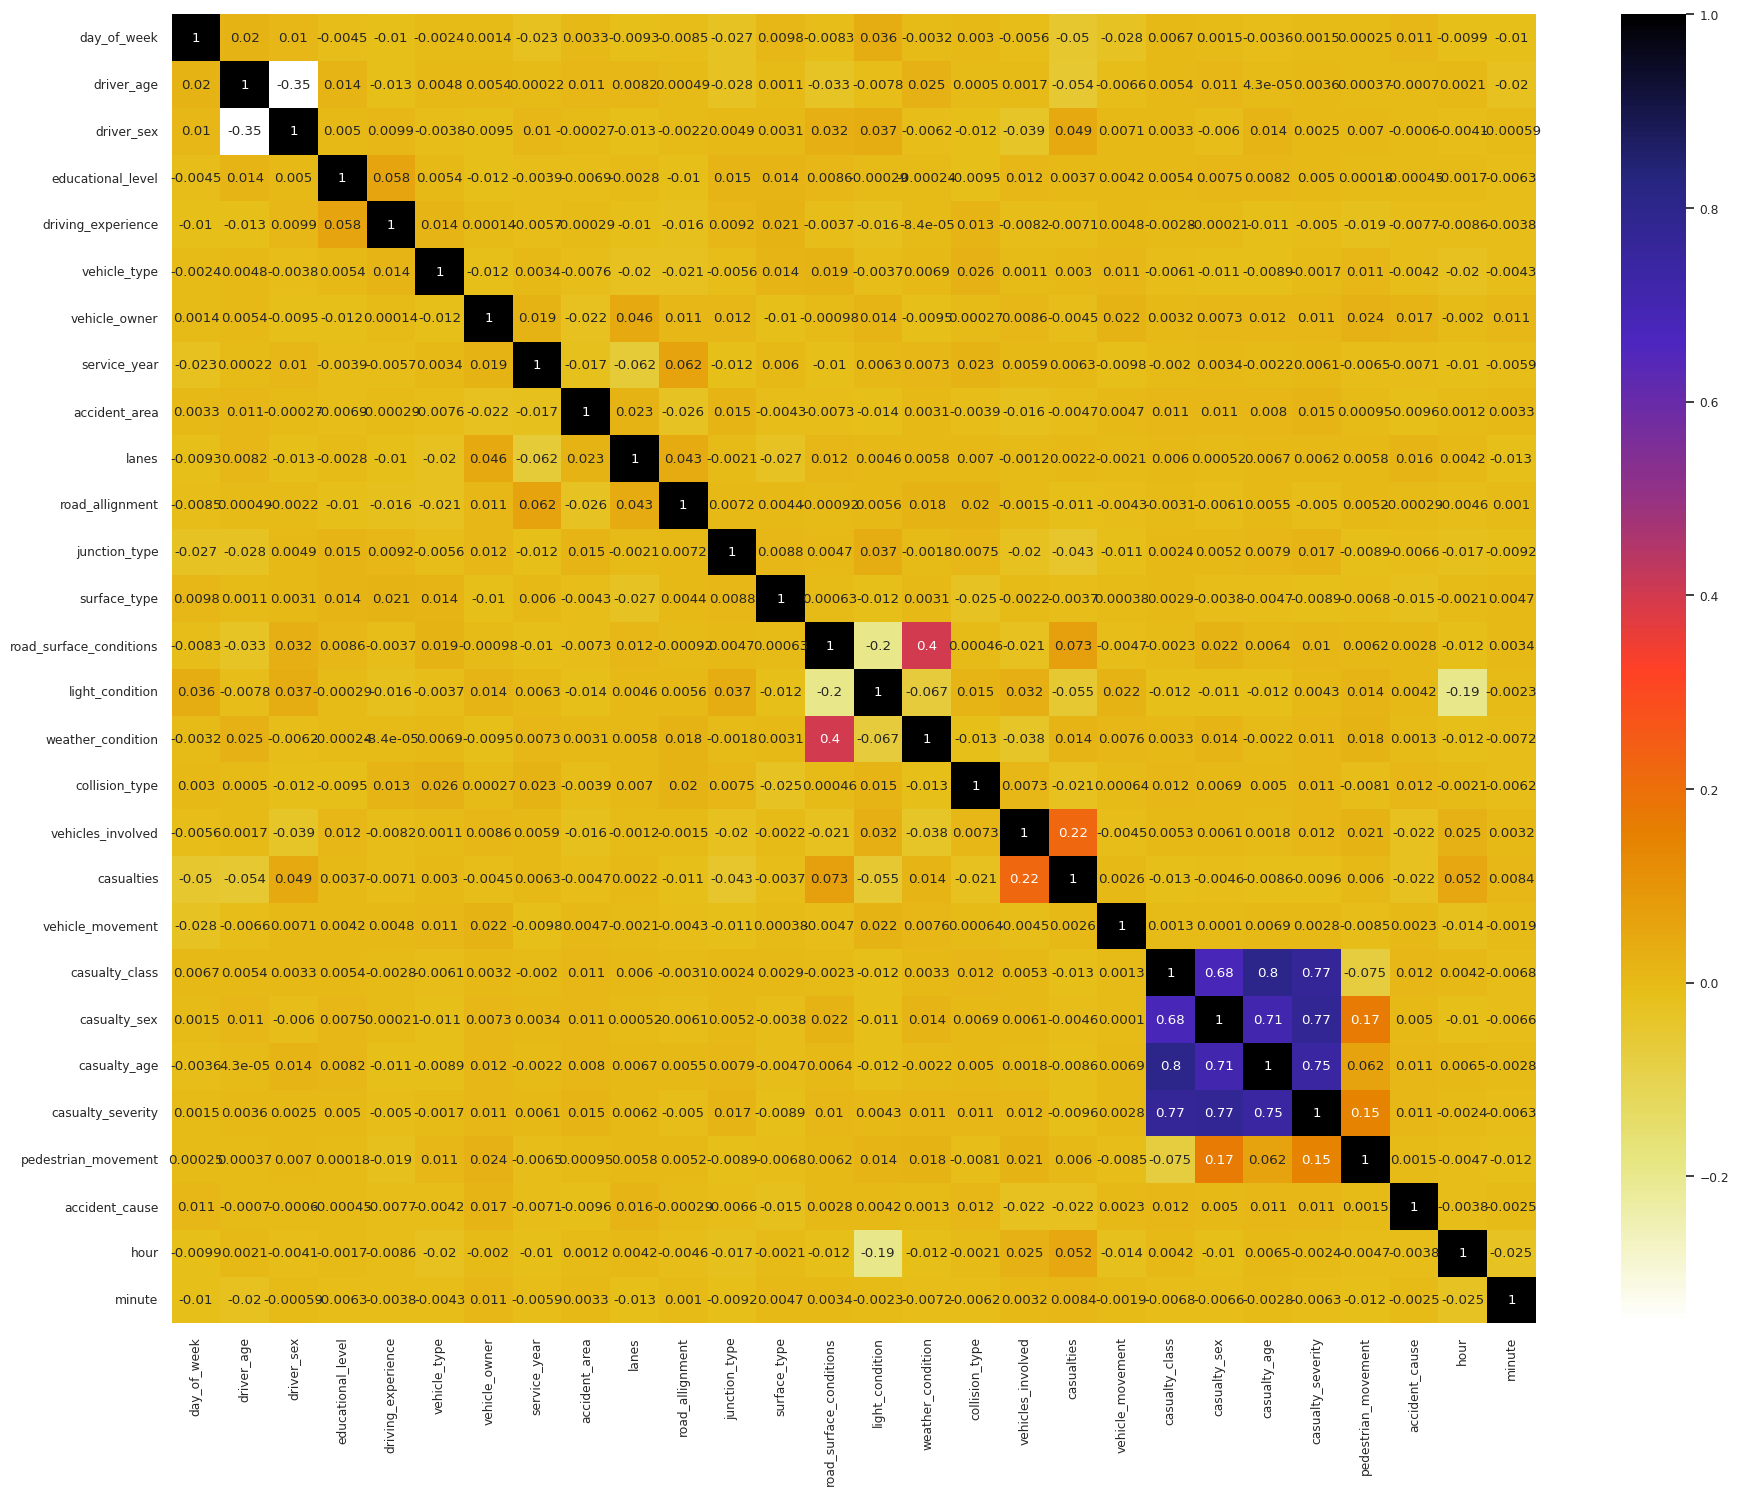

In [ ]:
plt.figure(figsize=(22,17))
sns.set(font_scale=0.8)
sns.heatmap(df.corr(), annot=True, cmap=plt.cm.CMRmap_r)

# Upsampling

In [ ]:
X = df.drop('accident_severity', axis=1)
y = df['accident_severity']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(8621, 28) (3695, 28) (8621,) (3695,)


In [ ]:
# upsampling using smote

counter = Counter(y_train)

print("=============================")

for k,v in counter.items():
    per = 100*v/len(y_train)
    print(f"Class= {k}, n={v} ({per:.2f}%)")

oversample = SMOTE()
X_train, y_train = oversample.fit_resample(X_train, y_train)

counter = Counter(y_train)

print("=============================")

for k,v in counter.items():
    per = 100*v/len(y_train)
    print(f"Class= {k}, n={v} ({per:.2f}%)")

print("=============================")

print("Upsampled data shape: ", X_train.shape, y_train.shape)

Class= Slight Injury, n=7324 (84.96%)
Class= Serious Injury, n=1191 (13.82%)
Class= Fatal injury, n=106 (1.23%)
Class= Slight Injury, n=7324 (33.33%)
Class= Serious Injury, n=7324 (33.33%)
Class= Fatal injury, n=7324 (33.33%)
Upsampled data shape:  (21972, 28) (21972,)


In [ ]:
y_test = ordinal_encoder(pd.DataFrame(y_test, columns = ['accident_severity']), pd.DataFrame(y_test, columns = ['accident_severity']).columns)['accident_severity']
y_train = ordinal_encoder(pd.DataFrame(y_train, columns = ['accident_severity']), pd.DataFrame(y_train, columns = ['accident_severity']).columns)['accident_severity']

# <span style="font-family:cursive;text-align:center">🧰 Baseline Modelling</span>

In [ ]:
def modelling(X_train, y_train, X_test, y_test, **kwargs):
    scores = {}
    models = []
    bvd = {}
    if 'xgb' in kwargs.keys() and kwargs['xgb']:
        xgb = XGBClassifier()
        xgb.fit(X_train._get_numeric_data(), np.ravel(y_train, order='C'))
        y_pred = xgb.predict(X_test._get_numeric_data())
        scores['xgb']= [accuracy_score(y_test, y_pred)]
        models.append(xgb)


    if 'rf' in kwargs.keys() and kwargs['rf']:
        rf = RandomForestClassifier(n_estimators=200)
        rf.fit(X_train, y_train)
        y_pred = rf.predict(X_test)
        scores['rf']= [accuracy_score(y_test, y_pred)]
        models.append(rf)

    if 'extree' in kwargs.keys() and kwargs['extree']:
        extree = ExtraTreesClassifier()
        extree.fit(X_train, y_train)
        y_pred = extree.predict(X_test)
        scores['extree'] = [accuracy_score(y_test, y_pred)]
        models.append(extree)
        
    return scores,models

In [ ]:
scores,models = modelling(X_train,y_train, X_test, y_test, xgb=True, rf=True, extree=True)
print(scores)

{'xgb': [0.7948579161028417], 'rf': [0.801894451962111], 'extree': [0.8100135317997293]}


<div class="alert alert-block alert-info" style="font-size:14px; font-family:verdana; line-height: 1.7em;">
    📌 &nbsp;<b><u>Accuracy Scores:</u></b><br>
    
*  XGB -> 79.24%<br>
*  Random Forrest -> 80.08%<br>
*  Extra Trees -> 80.94%<br>
  
</div>

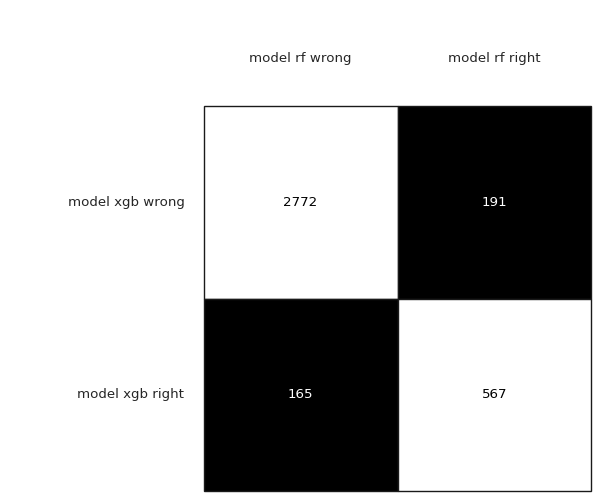

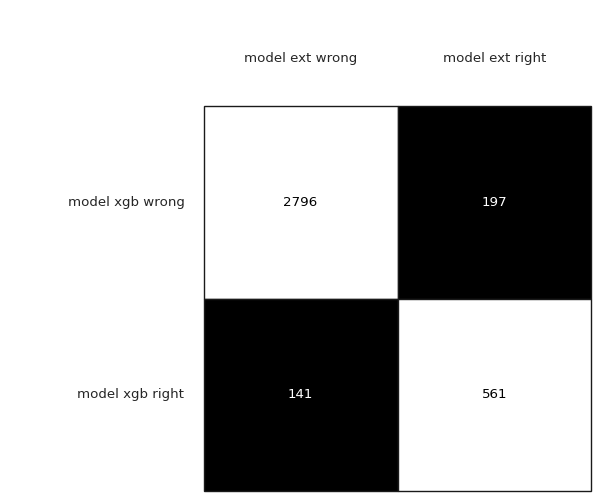

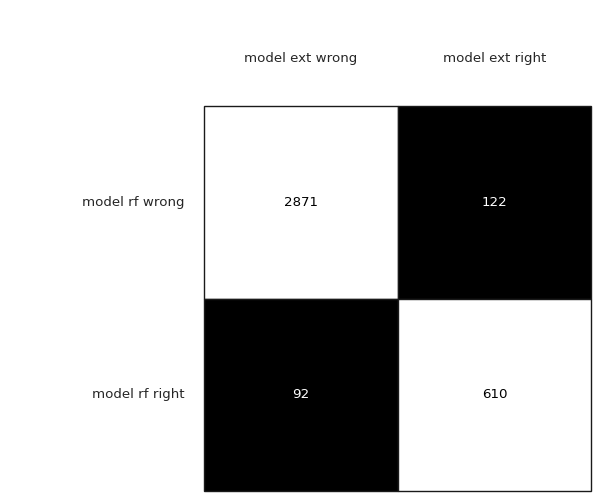

In [ ]:
y_pred_xgb = models[0].predict(X_test)
y_pred_rf = models[1].predict(X_test)
y_pred_ext = models[2].predict(X_test)


tb = mcnemar_tables(y_test, 
                    y_pred_xgb,
                    y_pred_rf, 
                    y_pred_ext)

brd = checkerboard_plot(tb['model_0 vs model_1'],
                        figsize=(5, 5),
                        fmt='%d',
                        col_labels=['model rf wrong', 'model rf right'],
                        row_labels=['model xgb wrong', 'model xgb right'])
plt.show()

brd = checkerboard_plot(tb['model_0 vs model_2'],
                        figsize=(5, 5),
                        fmt='%d',
                        col_labels=['model ext wrong', 'model ext right'],
                        row_labels=['model xgb wrong', 'model xgb right'])
plt.show()

brd = checkerboard_plot(tb['model_1 vs model_2'],
                        figsize=(5, 5),
                        fmt='%d',
                        col_labels=['model ext wrong', 'model ext right'],
                        row_labels=['model rf wrong', 'model rf right'])
plt.show()

In [ ]:
def model_performance(model, y_test, y_hat) : 
    conf_matrix = confusion_matrix(y_test, y_hat)
    trace1 = go.Heatmap(z = conf_matrix  ,x = ["0 (pred)","1 (pred)", "2 (pred)"],
                        y = ["0 (true)","1 (true)", "2 (true)"],xgap = 2, ygap = 2, 
                        colorscale = 'Viridis', showscale  = False)

    #Show metrics
    Accuracy  =  accuracy_score(y_test, y_hat)
    Precision =  precision_score(y_test, y_pred, average= 'weighted')
    Recall    =  recall_score(y_test, y_pred, average= 'weighted')
    F1_score  =  f1_score(y_test, y_pred, average= 'weighted')

    show_metrics = pd.DataFrame(data=[[Accuracy , Precision, Recall, F1_score]])
    show_metrics = show_metrics.T

    colors = ['gold', 'lightgreen', 'lightcoral', 'lightskyblue']
    trace2 = go.Bar(x = (show_metrics[0].values), 
                   y = ['Accuracy', 'Precision', 'Recall', 'F1_score'], text = np.round_(show_metrics[0].values,4),
                    textposition = 'auto',
                   orientation = 'h', opacity = 0.8,marker=dict(
            color=colors,
            line=dict(color='#000000',width=1.5)))
 
     
    #plots
    model = model
    
    #Subplots
    fig = tls.make_subplots(rows=2, cols=1, print_grid=False, 
                          subplot_titles=('Confusion Matrix',
                                        'Metrics',
                                        ))
    
    fig.append_trace(trace1,1,1)
    fig.append_trace(trace2,2,1)
    
    fig['layout'].update(showlegend = False, title = '<b>Model performance report</b><br>'+str(model),
                        autosize = True, height = 800,width = 800,
                        plot_bgcolor = 'rgba(240,240,240, 0.95)',
                        paper_bgcolor = 'rgba(240,240,240, 0.95)',
                        # margin = dict(b = 100)
                        )
    fig.layout.titlefont.size = 14
    
    py.iplot(fig,filename='model-performance')

In [ ]:
extree = ExtraTreesClassifier()
extree.fit(X_train, y_train)
y_pred = extree.predict(X_test)

In [ ]:
extree.get_params()

{'bootstrap': False,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [ ]:
model_performance(extree,y_test, y_pred)

# <span style="font-family:cursive;text-align:center">🛠️ Hyperparameter Tuning</span>

In [ ]:
gkf = KFold(n_splits=3, shuffle=True, random_state=42).split(X=X_train, y=y_train)

# A parameter grid for ETrees
params = {
    'n_estimators': range(100, 500, 100),  # [100,200,300,400,500]
    'ccp_alpha': [0.0, 0.1],
    'criterion': ['gini'],
    'max_depth': [5,11],
    'min_samples_split': [2,3],
}

extree_estimator = ExtraTreesClassifier()

gsearch = GridSearchCV(
    estimator= extree_estimator,
    param_grid= params,
    scoring='f1_weighted',
    n_jobs=-1,
    cv=gkf,
    verbose=1,
)


extree_model = gsearch.fit(X=X_train, y=y_train)
(gsearch.best_params_, gsearch.best_score_)

Fitting 3 folds for each of 32 candidates, totalling 96 fits


({'ccp_alpha': 0.0,
  'criterion': 'gini',
  'max_depth': 11,
  'min_samples_split': 2,
  'n_estimators': 100},
 0.8638630617954566)

<div class="alert alert-block alert-success" style="font-size:14px; font-family:verdana; line-height: 1.7em;">
   <b><u>Parameters:</u></b>
  'ccp_alpha':<span style="color:red">0.0</span>,
  'criterion': <span style="color:red">'gini'</span>,
  'max_depth': <span style="color:red">11</span>,
  'min_samples_split': <span style="color:red">2</span>,
  'n_estimators': <span style="color:red">400</span>
<br>
<b><u>Best Score: </u></b><span style="color:red">0.86</span><br>
</div>

In [ ]:
gkf2 = KFold(n_splits=3, shuffle=True, random_state=101).split(X=X_train, y=y_train)

params2 = {
    'max_depth': [11,15],
    'min_samples_split': [2,3],
    'class_weight': ['balanced', None],

}

extree2 = ExtraTreesClassifier(ccp_alpha = 0.0,
                                criterion = 'gini',
                                max_depth = 11,
                                min_samples_split = 3)

gsearch2 = GridSearchCV(
    estimator= extree2,
    param_grid= params2,
    scoring='f1_weighted',
    n_jobs=-1,
    cv=gkf2,
    verbose=3,
)

extree_model2 = gsearch2.fit(X=X_train, y=y_train)

(gsearch2.best_params_, gsearch2.best_score_)

Fitting 3 folds for each of 8 candidates, totalling 24 fits


({'class_weight': None, 'max_depth': 15, 'min_samples_split': 3},
 0.9202059893852851)

<div class="alert alert-block alert-success" style="font-size:14px; font-family:verdana; line-height: 1.7em;">
   <b><u>Parameters:</u></b>
  'class_weight':<span style="color:red">balanced</span>,
  'max_depth': <span style="color:red">15</span>,
  'min_samples_split': <span style="color:red">2</span>,
<br>
<b><u>Best Score: </u></b><span style="color:red">0.92</span><br>
</div>

In [ ]:
extree_tuned = ExtraTreesClassifier(ccp_alpha = 0.0,
                                criterion = 'gini',
                                min_samples_split = 2,
                                class_weight = 'balanced',
                                max_depth = 15,
                                n_estimators = 400)

extree_tuned.fit(X_train, y_train)

ExtraTreesClassifier(class_weight='balanced', max_depth=15, n_estimators=400)

In [ ]:
print(extree_tuned.feature_importances_)

[0.05845027 0.05700773 0.01526503 0.02977845 0.04509572 0.03464057
 0.01896503 0.03340155 0.02794315 0.03813945 0.01400569 0.04525627
 0.01142964 0.04627337 0.06216942 0.01730712 0.03326899 0.0685371
 0.06420768 0.02114052 0.02959632 0.02940171 0.02874643 0.02365847
 0.01089986 0.04011536 0.04268486 0.05261425]


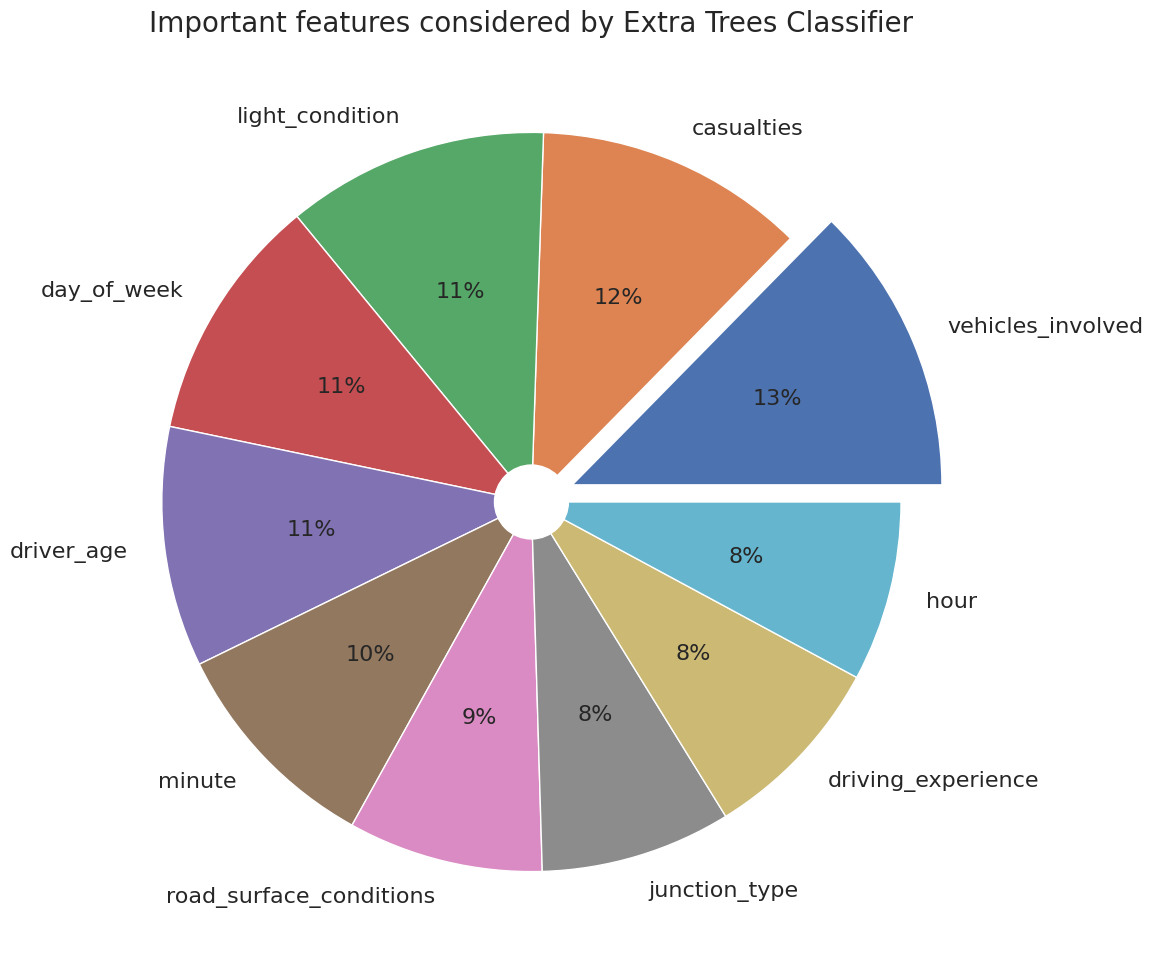

In [ ]:
feat_importances = pd.Series(extree_tuned.feature_importances_, index=X.columns)
plt.figure(figsize=(12,12))
myexplode = [0.12,0,0,0,0,0,0,0,0,0]
plt.pie(feat_importances.nlargest(10),labels=feat_importances.nlargest(10).index, autopct='%.0f%%',explode= myexplode,
        textprops={'fontsize': 16})
centre_circle = plt.Circle((0,0),0.10,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
plt.title('Important features considered by Extra Trees Classifier',fontsize=20)
plt.show()